In [1]:
# encoding moel can run on either the betas or the raw timeseries (convolved with a design matrix)
# the easiest way will be to run on the betas, in which case it's just a linear model

# plan:
# 1. mask image using graymatter (or ROI)
# 2. Run linear model for each feature
# 3. Turn mask back into brain.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')

In [4]:
import json

import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score, permutation_test_score

from joblib import Parallel, delayed
import multiprocessing

MAX_CPU = multiprocessing.cpu_count() // 2

In [5]:
from analysis.fmri.analogy_rsa import \
downsample_rdms_df_by_factor, create_models, models_to_df, plotmodels,\
roi_rdm, run_rsa_dfs, subject_rdms, plot_results

from analysis.fmri.analogy_utils import \
    projectSettings, analysisSettings, contrastSettings, order, \
    pu, pa, pv, compile_models, rsa, save_rois, load_rois, load_betas

paths = projectSettings["filepaths"]["hoffPaths"]

/u/home/n/njchiang/.conda/envs/fmri/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Loading JSON config from config/analyses.json
Loading JSON config from config/contrasts.json
Loading label file from: labels/trialorder_rsa_absorted.csv


In [8]:
accuracies = pu.load_labels(paths["code"], "labels", "group_accuracy.csv").set_index("Trial")

raw_models_df = pu.load_labels(os.path.join(paths["code"], "labels", "raw_models.csv"))

bart270_df = (raw_models_df
            .reset_index(drop=True)
            .set_index("ABTag")[
                [c for c in raw_models_df.columns if "rstpostprob270" in c]
            ])

bartpower_df = (raw_models_df
            .reset_index(drop=True)
            .set_index("ABTag")[
                [c for c in raw_models_df.columns if "bart79power" in c]
            ])  

bartnorm_df = (raw_models_df
            .reset_index(drop=True)
            .set_index("ABTag")[
                [c for c in raw_models_df.columns if "bart79norm" in c]
            ])  

bart_df = (raw_models_df
            .reset_index(drop=True)
            .set_index("ABTag")[
                [c for c in raw_models_df.columns if "rstpostprob79" in c]
            ])  

w2vc_df = (raw_models_df
            .reset_index(drop=True)
            .set_index("ABTag")[
                [c for c in raw_models_df.columns if "concatword" in c]
            ])  

w2vd_df = (raw_models_df
            .reset_index(drop=True)
            .set_index("ABTag")[
                [c for c in raw_models_df.columns if "w2vdiff" in c]
            ])  

model_names = ["Word2vec-diff", "Word2vec-concat", "BART"]
bartnorm_df.shape, bart270_df.shape

Loading label file from: /u/project/monti/Analysis/Analogy/code/analogy-fmri/labels/group_accuracy.csv
Loading label file from: /u/project/monti/Analysis/Analogy/code/analogy-fmri/labels/raw_models.csv


((288, 79), (288, 270))

In [6]:
maskname = "ab_bart79_95-bin_mask"
sub = "sub-01"
mask = pu.load_img(paths["root"], "derivatives", sub, "masks", "{}.nii.gz".format(maskname))
fmri_data, labels, bg_image = load_betas(projectSettings, 
                                         sub, 
                                         t="cope-LSS", center=True, scale=False)

fmri_data = pu.mask_img(fmri_data, mask)

trials = labels[(labels.AB == 1)]

# fmri_data = fmri_data[trials.index]
# labels = labels.loc[trials.index]

Reading file from: /u/project/monti/Analysis/Analogy/derivatives/sub-01/masks/ab_bart79_95-bin_mask.nii.gz
centering image
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-01/func/sub-01_task-analogy_run-01_events.csv
centering image
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-01/func/sub-01_task-analogy_run-02_events.csv
centering image
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-01/func/sub-01_task-analogy_run-03_events.csv
centering image
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-01/func/sub-01_task-analogy_run-04_events.csv
centering image
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-01/func/sub-01_task-analogy_run-05_events.csv
centering image
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-01/func/sub-01_task-analogy_run-06_events.csv
centering image
Loading label file from: /u/project/monti/Analysis/Anal

In [34]:
trials = trials.sort_values("ABTag")
fmri_data = fmri_data[trials.index]
fmri_data = (fmri_data[::2] + fmri_data[1::2]) / 2
labels = trials.iloc[::2]

In [35]:
features = bartnorm_df.loc[[tag for tag in labels["ABTag"]], :].iloc[::2]

In [36]:
features

,bart79norm_1,bart79norm_2,bart79norm_3,bart79norm_4,bart79norm_5,bart79norm_6,bart79norm_7,bart79norm_8,bart79norm_9,bart79norm_10,...,bart79norm_70,bart79norm_71,bart79norm_72,bart79norm_73,bart79norm_74,bart79norm_75,bart79norm_76,bart79norm_77,bart79norm_78,bart79norm_79
ABTag,,,,,,,,,,,,,,,,,,,,,
acceleration:speed,0.004664,0.018432,0.018632,0.015403,0.008221,0.008146,0.000857,0.008878,0.000419,0.004462,...,0.008604,0.001746,0.017449,0.010036,0.013103,0.010152,0.018070,0.004930,0.002027,0.011712
accept:reject,0.012125,0.005434,0.011668,0.014329,0.014345,0.025550,0.010716,0.016177,0.006904,0.002346,...,0.004837,0.001613,0.005962,0.006372,0.025273,0.006258,0.024387,0.000972,0.004388,0.010877
accident:damage,0.011706,0.000283,0.010433,0.005544,0.019428,0.006893,0.006368,0.007449,0.018214,0.003759,...,0.017074,0.018360,0.019487,0.009038,0.008347,0.001511,0.013861,0.009020,0.011273,0.024489
advertise:promote,0.009647,0.003536,0.016831,0.004293,0.007511,0.004296,0.008472,0.005312,0.018077,0.016639,...,0.009953,0.003390,0.010838,0.001139,0.011345,0.025630,0.005461,0.019810,0.000638,0.018499
ahead:behind,0.000655,0.012133,0.017617,0.013234,0.012846,0.012059,0.024994,0.024947,0.015005,0.000562,...,0.011568,0.002641,0.016340,0.008534,0.002212,0.004566,0.010790,0.015319,0.000763,0.001653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
warm:cool,0.006877,0.009293,0.013690,0.004637,0.018103,0.019808,0.017854,0.021112,0.016069,0.011607,...,0.016373,0.006869,0.017397,0.003663,0.014642,0.006870,0.011011,0.022866,0.002400,0.006964
wash:clean,0.006643,0.013013,0.013843,0.010331,0.011808,0.002416,0.002444,0.005467,0.006114,0.015844,...,0.002153,0.004906,0.011836,0.007617,0.011555,0.015242,0.010368,0.000689,0.007041,0.006465
witty:dumb,0.015565,0.016881,0.023538,0.022032,0.013081,0.012457,0.000647,0.013892,0.000970,0.008454,...,0.023714,0.007096,0.012912,0.001784,0.021827,0.002241,0.012306,0.019521,0.013298,0.011797


In [37]:
groups = labels["SubRel"]

In [39]:
labels

,Onset,Duration,TrialTag,ABTag,CDTag,Match,ABMainRel,CDMainRel,ABSubRel,CDSubRel,...,ProbeCorr,ProbeArr,AB,CD,Probe,Intensity,TrialType,chunks,MainRel,SubRel
804,120.9789,2.0080,acceleration:speed::enthusiastic:lazy,acceleration:speed,None,None,1,None,3,None,...,0,0,1,0,0,1.0,AB,8,1,3
15,42.0461,2.0079,accept:reject::lower:volume,accept:reject,None,None,2,None,4,None,...,0,0,1,0,0,1.0,AB,1,2,4
774,48.4808,2.0099,accident:damage::make:manufacture,accident:damage,None,None,3,None,7,None,...,0,0,1,0,0,1.0,AB,8,3,7
861,261.5684,2.0095,advertise:promote::wash:clean,advertise:promote,None,None,3,None,9,None,...,0,0,1,0,0,1.0,AB,8,3,9
114,18.3638,2.0101,ahead:behind::bath:cleanliness,ahead:behind,None,None,2,None,5,None,...,0,0,1,0,0,1.0,AB,2,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,240.4211,2.0107,warm:cool::read:learn,warm:cool,None,None,2,None,4,None,...,0,0,1,0,0,1.0,AB,3,2,4
69,178.4993,2.0105,wash:clean::cook:eat,wash:clean,None,None,3,None,9,None,...,0,0,1,0,0,1.0,AB,1,3,9
720,181.5790,2.0083,witty:dumb::loss:grief,witty:dumb,None,None,2,None,6,None,...,0,0,1,0,0,1.0,AB,7,2,6
63,161.9592,2.0107,work:earn::stairs:ladder,work:earn,None,None,3,None,9,None,...,0,0,1,0,0,1.0,AB,1,3,9


In [40]:
cv = StratifiedKFold(5)

cv_splits = cv.split(features, groups, groups=groups)

In [41]:
train, test = next(cv_splits)

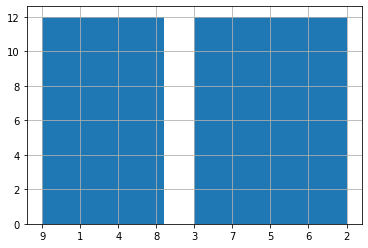

In [44]:
labels.iloc[train].ABSubRel.hist()

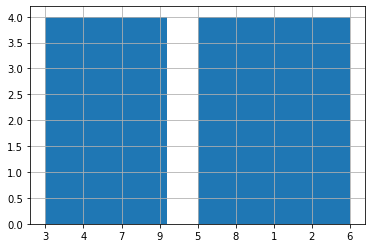

In [43]:
labels.iloc[test].ABSubRel.hist()

In [10]:
model_df = bart270_df.iloc[::2]
features = model_df.loc[[tag for tag in labels["ABTag"]], :]
features.shape

(864, 270)

In [ ]:
trials = labels[labels.AB == 1].sort_values("ABTag")



In [ ]:
trials.iloc[::2].ABTag.unique().shape

In [14]:
features.shape, fmri_data.shape, groups.shape

((864, 270), (864, 2092), (288,))

In [23]:
def run_cv_voxel(v, model, features, fmri_data, cv, groups, scoring, permutations=None):
    cv_splits = cv.split(features, groups, groups=groups)
    if permutations:
        score, _, pvalue = permutation_test_score(model, features, fmri_data[:, v], groups=groups, scoring=scoring, cv=cv_splits, n_permutations=permutations, n_jobs=1)
        return score, pvalue
    else:
        score = np.mean(cross_val_score(model, features, fmri_data[:, v], groups=groups, scoring=scoring, cv=cv_splits, n_jobs=1))
        return score
    
from sklearn.metrics import fbeta_score, make_scorer

def corrcoef(y, y_pred):
    return np.corrcoef(y, y_pred)[0, 1]

mname = "bartpower"
tag_key = "ABTag"
groups = trials["SubRel"]
cv = StratifiedKFold(5)

# pipeline = Pipeline(steps=[("standardize", StandardScaler()), ("ridge", Ridge())])
model_df = bart270_df.iloc[::2]
features = model_df.loc[[tag for tag in trials["ABTag"]], :]



In [28]:
run_cv_voxel(0, Ridge(), features, fmri_data[trials.index], cv, groups, make_scorer(corrcoef), permutations=1000)

(0.07791484200804955, 0.13586413586413587)

In [29]:
result = Parallel(n_jobs=MAX_CPU)(delayed(run_cv_voxel)(v, Ridge(), features, fmri_data[trials.index], cv, groups, make_scorer(corrcoef), 10) for v in range(fmri_data.shape[1]))

In [31]:
np.array(result)[:, 1].shape

(2092,)

In [20]:
from analysis.run_encoding import run_voxel, run_cv_voxel


ModuleNotFoundError: No module named 'fmri'

In [ ]:
from analysis.run_encoding import run_voxel, run_cv_voxel

maskname = "graymatter-bin_mask"
# maskname = "dfc-left-ba10_mask"

results = {}
# for sub in ["sub-01", "sub-02"]:
# for sub in ["sub-03", "sub-04"]:
for sub in ["sub-05", "sub-06"]:
    print(sub)
    mask = pu.load_img(paths["root"], "derivatives", sub, "masks", "{}.nii.gz".format(maskname))
    fmri_data, labels, bg_image = load_betas(projectSettings, 
                                             sub, 
                                             t="cope-LSS", center=True, scale=False)

    fmri_data = pu.mask_img(fmri_data, mask)

    trials = labels[(labels.AB == 1)]

    fmri_data = fmri_data[trials.index]
    labels = labels.loc[trials.index]

    results[sub] = {}
    for mname, model_df in zip(model_names, [w2vd_df, w2vc_df, bart_df]):
        logging.info("Running {}".format(mname))
        features = model_df.loc[[tag for tag in labels[tag_key]], :]
        result = Parallel(n_jobs=MAX_CPU)(delayed(run_voxel)(v, features, fmri_data) for v in range(fmri_data.shape[1]))
        result = np.array(result)
#         pu.unmask_img(result, mask).to_filename(
#                 os.path.join(paths["root"], "analysis", sub, "encoding", "{}-{}-{}_{}.nii.gz".format(sub, mname, "cope-LSS", FLAGS.phase)))


sub-05
Reading file from: /u/project/monti/Analysis/Analogy/derivatives/sub-05/masks/graymatter-bin_mask.nii.gz
centering image
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-05/func/sub-05_task-analogy_run-01_events.csv
centering image
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-05/func/sub-05_task-analogy_run-02_events.csv
centering image
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-05/func/sub-05_task-analogy_run-03_events.csv
centering image
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-05/func/sub-05_task-analogy_run-04_events.csv
centering image
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-05/func/sub-05_task-analogy_run-05_events.csv
centering image
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-05/func/sub-05_task-analogy_run-06_events.csv
centering image
Loading label file from: /u/project/monti/Analysis

# By relation

In [45]:
%%bash
#     -V -N ab-encoding_relation_rerun \

# previously was run with only 5 folds, using kfold. switched to shuffle split to check
qsub \
    -o /u/project/monti/njchiang/code/analogy/jobs/output/ \
    -e /u/project/monti/njchiang/code/analogy/jobs/output/ \
    -V -N ab-encoding_relation_avg_rerun \
    -l h_data=8G,h_rt=23:59:59 -pe shared 8 \
    -M ${USER} -m bea \
    /u/project/monti/njchiang/code/analogy/analogy-fmri/analysis/scripts/submit/run_ab_encoding_relation.sh

Your job 1204477 ("ab-encoding_relation_avg_rerun") has been submitted


In [33]:
%%bash
#     -V -N ab-encoding_relation_rerun \

# previously was run with only 5 folds, using kfold. switched to shuffle split to check
qsub \
    -o /u/project/monti/njchiang/code/analogy/jobs/output/ \
    -e /u/project/monti/njchiang/code/analogy/jobs/output/ \
    -V -N ab-encoding_relation_avg_perm \
    -l h_data=8G,h_rt=23:59:59 -pe shared 8 \
    -M ${USER} -m bea \
    /u/project/monti/njchiang/code/analogy/analogy-fmri/analysis/scripts/submit/run_ab_encoding_relation_perm.sh

Your job 1242668 ("ab-encoding_relation_avg_perm") has been submitted


In [1]:
%%bash

. ~/.bashrc

module load fsl
cd /u/project/monti/Analysis/Analogy

sel=AB


for m in BARTpower BARTnorm BART Word2vec-diff Word2vec-concat BART270 # accuracy # rstpostprob79 rstpostprob9 w2vdiff concatword
do
  echo ${m}
  for s in 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16
  do
    echo sub-${s}
      flirt -in analysis/sub-${s}/encoding/sub-${s}_${m}_cope-LSS_${sel}_cv-relation \
      -out analysis/group/encoding/sub-${s}_${m}_${sel}_cv-relation \
      -ref derivatives/standard/MNI152_T1_2mm_brain.nii.gz \
      -applyxfm -init derivatives/sub-${s}/reg/BOLD_template_to_standard.mat
    fslmaths analysis/group/encoding/sub-${s}_${m}_${sel}_cv-relation -nan analysis/group/encoding/sub-${s}_${m}_${sel}_cv-relation
  done
  fslmerge -t analysis/group/encoding/group-ab_${m}_cv-relation.nii.gz analysis/group/encoding/sub*_${m}_${sel}_cv-relation.nii.gz
  rm analysis/group/encoding/sub*_${m}_${sel}_cv-relation.nii.gz

done


#       flirt -in analysis/sub-${s}/encoding/sub-${s}-${m}-cope-LSS_${sel}_cv-relation \

BARTpower
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
BARTnorm
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
BART
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
Word2vec-diff
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
Word2vec-concat
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
BART270
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16


In [2]:
%%bash

. ~/.bashrc
module load fsl

n=5000
cd /u/project/monti/Analysis/Analogy

for m in BART270 BARTpower BARTnorm BART Word2vec-diff Word2vec-concat # rstpostprob79 rstpostprob9 w2vdiff concatword
do
    randomise -i analysis/group/encoding/ab-mainrel-kfold-elasticnet-lambda1/group-ab_${m}_cv-relation \
      -o analysis/group/encoding/n${n}-ab_${m}_cv-relation \
      -m derivatives/standard/masks/grayMatter \
      -n ${n} -1 -T --uncorrp -v 10 -x 
done


randomise options: -i analysis/group/encoding/group-ab_BARTpower_cv-relation -o analysis/group/encoding/n1000-ab_BARTpower_cv-relation -m derivatives/standard/masks/grayMatter -n 1000 -1 -T --uncorrp -v 10 
Loading Data: 
Data loaded
One-sample design detected; sign-flipping instead of permuting.
65536 sign-flips required for exhaustive test of t-test 1
Doing 1000 random permutations
Starting permutation 1 (Unpermuted data)
Starting permutation 2
Starting permutation 3
Starting permutation 4
Starting permutation 5
Starting permutation 6
Starting permutation 7
Starting permutation 8
Starting permutation 9
Starting permutation 10
Starting permutation 11
Starting permutation 12
Starting permutation 13
Starting permutation 14
Starting permutation 15
Starting permutation 16
Starting permutation 17
Starting permutation 18
Starting permutation 19
Starting permutation 20
Starting permutation 21
Starting permutation 22
Starting permutation 23
Starting permutation 24
Starting permutation 25
Star

## Follow up with FDR for group stats

seems like not significant

In [21]:
%%bash

. ~/.bashrc
module load fsl

n=1000
cd /u/project/monti/Analysis/Analogy

resultdir=analysis/group/encoding/ab-mainrel-kfold-elasticnet-lambda1

for m in BART270 BARTpower BARTnorm BART Word2vec-diff Word2vec-concat # rstpostprob79 rstpostprob9 w2vdiff concatword
do
#     fslmaths ${resultdir}/n${n}-ab_${m}_cv-relation_tfce_p_tstat1 -mul -1 -add 1 ${SCRATCH}/tmp.nii.gz
#     fdr -i ${SCRATCH}/tmp -q 0.05 \
    fdr -i ${resultdir}/n${n}-ab_${m}_cv-relation_tfce_p_tstat1 --oneminusp \
        -a ${resultdir}/n${n}-ab_${m}_cv-relation_tfce_fdrp_tstat1 \
        -m derivatives/standard/masks/grayMatter
        # -q 0.05--othresh=${resultdir}/thresh_n${n}-ab_${m}_cv-relation_tfce_p_tstat1 \
    
    fslmaths ${resultdir}/n${n}-ab_${m}_cv-relation_tfce_p_tstat1 -mul -1 -add 1 ${SCRATCH}/tmp.nii.gz
#     fdr -i ${SCRATCH}/tmp -q 0.05 \
    fdr -i ${resultdir}/n${n}-ab_${m}_cv-relation_vox_p_tstat1 --oneminusp \
        -a ${resultdir}/n${n}-ab_${m}_cv-relation_vox_fdrp_tstat1 \
        -m derivatives/standard/masks/grayMatter
        # -q 0.05 --othresh=${resultdir}/thresh_n${n}-ab_${m}_cv-relation_vox_p_tstat1 \

done


Probability Threshold is: 
0.02
Probability Threshold is: 
0
Probability Threshold is: 
0.011
Probability Threshold is: 
0
Probability Threshold is: 
0.311
Probability Threshold is: 
0
Probability Threshold is: 
0.495
Probability Threshold is: 
0
Probability Threshold is: 
0
Probability Threshold is: 
0
Probability Threshold is: 
0
Probability Threshold is: 
0


In [61]:
%%bash

. ~/.bashrc
module load fsl

n=1000
cd /u/project/monti/Analysis/Analogy

resultdir=analysis/group/encoding/ab-mainrel-kfold-elasticnet-lambda1

for m in BART270 BARTpower BARTnorm BART Word2vec-diff Word2vec-concat # rstpostprob79 rstpostprob9 w2vdiff concatword
do
#     fslmaths ${resultdir}/n${n}-ab_${m}_cv-relation_tfce_p_tstat1 -mul -1 -add 1 ${SCRATCH}/tmp.nii.gz
#     fdr -i ${SCRATCH}/tmp -q 0.05 \
    fdr -i ${resultdir}/n${n}-ab_${m}_cv-relation_tfce_p_tstat1 --oneminusp -q 0.05 \
        -m ${resultdir}/n${n}-ab_${m}_cv-relation_tfce_p_tstat1
#         -a ${resultdir}/n${n}-ab_${m}_cv-relation_tfce_fdrp_tstat1 \
        # -q 0.05--othresh=${resultdir}/thresh_n${n}-ab_${m}_cv-relation_tfce_p_tstat1 \
    
#     fslmaths ${resultdir}/n${n}-ab_${m}_cv-relation_tfce_p_tstat1 -mul -1 -add 1 ${SCRATCH}/tmp.nii.gz
#     fdr -i ${SCRATCH}/tmp -q 0.05 \
    fdr -i ${resultdir}/n${n}-ab_${m}_cv-relation_vox_p_tstat1 --oneminusp -q 0.05 \
        -m ${resultdir}/n${n}-ab_${m}_cv-relation_vox_p_tstat1
#         -a ${resultdir}/n${n}-ab_${m}_cv-relation_vox_fdrp_tstat1 \
        # -q 0.05 --othresh=${resultdir}/thresh_n${n}-ab_${m}_cv-relation_vox_p_tstat1 \

done


Probability Threshold is: 
0
Probability Threshold is: 
0
Probability Threshold is: 
0
Probability Threshold is: 
0
Probability Threshold is: 
0
Probability Threshold is: 
0
Probability Threshold is: 
0
Probability Threshold is: 
0
Probability Threshold is: 
0
Probability Threshold is: 
0
Probability Threshold is: 
0
Probability Threshold is: 
0


In [58]:
# fdr correction (python)
from statsmodels.stats.multitest import multipletests
modelname="BART"
maskname = "rois-bin"
mask = pu.load_img(paths["root"], "derivatives", "standard", "masks", "{}.nii.gz".format(maskname))
img_path = os.path.join(paths["root"], "analysis/group/encoding/ab-mainrel-kfold-elasticnet-lambda1", "n1000-ab_{}_cv-relation_tfce_p_tstat1.nii.gz".format(modelname))

fmri_data = pu.mask_img(img_path, mask)
print(min(fmri_data), max(fmri_data))
_, corrp, _, _ = multipletests(1 - fmri_data, alpha=0.05, method="fdr_bh")
min(corrp), max(corrp)

Reading file from: /u/project/monti/Analysis/Analogy/derivatives/standard/masks/rois-bin.nii.gz
Applying mask
0.0 0.9990000128746033


(0.0627012800220294, 1.0)

In [59]:
_, corrp, _, _ = multipletests(1 - fmri_data[fmri_data > 0], alpha=0.05, method="fdr_bh")
min(corrp), max(corrp)

(0.021925713916431114, 0.5130000114440918)

(array([1260.,  264.,  169.,  136.,  189.,  162.,  146.,  178.,  184.,
        8837.]),
 array([0.02186879, 0.06958191, 0.11729503, 0.16500816, 0.21272128,
        0.2604344 , 0.30814752, 0.35586065, 0.40357377, 0.45128689,
        0.49900001]),
 <a list of 10 Patch objects>)

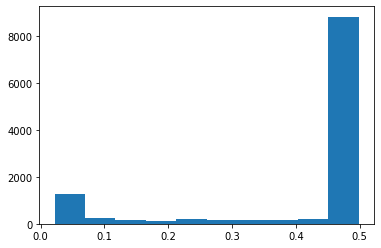

In [57]:
%matplotlib inline
plt.hist(corrp)

## Try single subject stats

Each subject was the average of 4 r values.

... assuming this r is an estimate of getting r for the whole sample, we can get a t value per subject...

t = (r / sqrt((1-r^2)/(N-2)) N = 144

In [8]:
modelname="BART"
maskname = "graymatter-bin_mask"
mask = pu.load_img(paths["root"], "derivatives", "standard", "masks", "{}.nii.gz".format(maskname))
img_path = os.path.join(paths["root"], "analysis/group/encoding/ab-mainrel-kfold-elasticnet-lambda1", "group-ab_{}_cv-relation.nii.gz".format(modelname))

fmri_data = pu.mask_img(img_path, mask)
# print(min(fmri_data), max(fmri_data))
# _, corrp, _, _ = multipletests(1 - fmri_data, alpha=0.05, method="fdr_bh")
# min(corrp), max(corrp)

Reading file from: /u/project/monti/Analysis/Analogy/derivatives/standard/masks/graymatter-bin_mask.nii.gz
Applying mask


In [33]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

rs = fmri_data[15]

ts = (rs / np.sqrt((1 - rs**2) / (144 - 2)))

pvals = stats.t.sf(ts, df=142)

_, corrp, _, _ = multipletests(pvals, alpha=0.05, method="fdr_bh")
corrp.min(), corrp.max()

(0.005085786590393916, 0.999994889168032)

(0.13844720007204728, 0.9999875294582458)

# By run

In [18]:
%%bash
qsub \
    -o /u/project/monti/njchiang/code/analogy/jobs/output/ \
    -e /u/project/monti/njchiang/code/analogy/jobs/output/ \
    -V -N ab-encoding_run \
    -l h_data=8G,h_rt=23:59:59 -pe shared 4 \
    -M ${USER} -m bea \
    /u/project/monti/njchiang/code/analogy/analogy-fmri/analysis/scripts/submit/run_ab_encoding_run.sh

Your job 717960 ("ab-encoding_run") has been submitted


In [1]:
%%bash
. ~/.bashrc
module load fsl
cd /u/project/monti/Analysis/Analogy
sel=AB
for m in BART Word2vec-diff Word2vec-concat # accuracy # rstpostprob79 rstpostprob9 w2vdiff concatword
do
  echo ${m}
  for s in 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16
  do
    echo sub-${s}
      flirt -in analysis/sub-${s}/encoding/sub-${s}-${m}-cope-LSS_${sel}_cv-run \
      -out analysis/group/encoding/sub-${s}_${m}_${sel}_cv-run \
      -ref derivatives/standard/MNI152_T1_2mm_brain.nii.gz \
      -applyxfm -init derivatives/sub-${s}/reg/BOLD_template_to_standard.mat  
      fslmaths analysis/group/encoding/sub-${s}_${m}_${sel}_cv-run -nan analysis/group/encoding/sub-${s}_${m}_${sel}_cv-run
  done
  fslmerge -t analysis/group/encoding/group-ab_${m}_cv-run.nii.gz analysis/group/encoding/sub*_${m}_${sel}_cv-run.nii.gz
  rm analysis/group/encoding/sub*_${m}_${sel}_cv-run.nii.gz

done


BART
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
Word2vec-diff
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
Word2vec-concat
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16


In [2]:
%%bash

. ~/.bashrc
module load fsl

n=1000
cd /u/project/monti/Analysis/Analogy

for m in BART Word2vec-diff Word2vec-concat # rstpostprob79 rstpostprob9 w2vdiff concatword
do
    randomise -i analysis/group/encoding/group-ab_${m}_cv-run \
      -o analysis/group/encoding/n${n}-ab_${m}_cv-run \
      -m derivatives/standard/masks/grayMatter \
      -n ${n} -1 -T --uncorrp -v 10
done


randomise options: -i analysis/group/encoding/group-ab_BART_cv-run -o analysis/group/encoding/n1000-ab_BART_cv-run -m derivatives/standard/masks/grayMatter -n 1000 -1 -T --uncorrp -v 10 
Loading Data: 
Data loaded
One-sample design detected; sign-flipping instead of permuting.
65536 sign-flips required for exhaustive test of t-test 1
Doing 1000 random permutations
Starting permutation 1 (Unpermuted data)
Starting permutation 2
Starting permutation 3
Starting permutation 4
Starting permutation 5
Starting permutation 6
Starting permutation 7
Starting permutation 8
Starting permutation 9
Starting permutation 10
Starting permutation 11
Starting permutation 12
Starting permutation 13
Starting permutation 14
Starting permutation 15
Starting permutation 16
Starting permutation 17
Starting permutation 18
Starting permutation 19
Starting permutation 20
Starting permutation 21
Starting permutation 22
Starting permutation 23
Starting permutation 24
Starting permutation 25
Starting permutation 26


# Beta analysis

In [2]:
%%bash

qsub \
    -o /u/project/monti/njchiang/code/analogy/jobs/output/ \
    -e /u/project/monti/njchiang/code/analogy/jobs/output/ \
    -V -N ab-encoding-betas_rerun_avg \
    -l h_data=8G,h_rt=23:59:59 -pe shared 2 \
    -M ${USER} -m bea \
    /u/project/monti/njchiang/code/analogy/analogy-fmri/analysis/scripts/submit/run_ab_encoding_betas.sh

Your job 964965 ("ab-encoding-betas_rerun_avg") has been submitted


In [3]:
%%bash

. ~/.bashrc

module load fsl
cd /u/project/monti/Analysis/Analogy

sel=AB

m=graymatter-bin_mask
echo ${m}
for model in BARTpower BARTnorm BART
do
echo ${model}
mkdir analysis/group/encoding/betas/split
for s in 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16
do
  echo sub-${s}

#   flirt -in analysis/sub-${s}/multivariate/rsa/sub-${s}_${m}_AB_corr_rsaSearchlight.nii.gz \
  flirt -in analysis/sub-${s}/encoding/sub-${s}_${model}_cope-LSS_AB_encoding-betas.nii.gz \
  -out analysis/group/encoding/betas/sub-${s}_${model}_AB_encoding-betas.nii.gz \
  -ref derivatives/standard/MNI152_T1_2mm_brain.nii.gz \
  -applyxfm -init derivatives/sub-${s}/reg/BOLD_template_to_standard.mat
  fslmaths analysis/group/encoding/betas/sub-${s}_${model}_AB_encoding-betas.nii.gz -nan analysis/group/encoding/betas/sub-${s}_${model}_AB_encoding-betas.nii.gz
  fslsplit analysis/group/encoding/betas/sub-${s}_${model}_AB_encoding-betas.nii.gz analysis/group/encoding/betas/split/sub-${s}_
  rm analysis/group/encoding/betas/sub-${s}_${model}_AB_encoding-betas.nii.gz
done

# fslmerge -t analysis/group/multivariate/rsa/group_${m}_AB.nii.gz analysis/group/multivariate/rsa/sub*_${m}_AB_rsaSearchlight.nii.gz

fslmerge -t analysis/group/encoding/betas/group_${model}_AB_3a analysis/group/encoding/betas/split/*0015.nii.gz 
fslmerge -t analysis/group/encoding/betas/group_${model}_AB_3f analysis/group/encoding/betas/split/*0020.nii.gz 
fslmerge -t analysis/group/encoding/betas/group_${model}_AB_3h analysis/group/encoding/betas/split/*0022.nii.gz 
fslmerge -t analysis/group/encoding/betas/group_${model}_AB_4b analysis/group/encoding/betas/split/*0024.nii.gz 
fslmerge -t analysis/group/encoding/betas/group_${model}_AB_4d analysis/group/encoding/betas/split/*0026.nii.gz 
fslmerge -t analysis/group/encoding/betas/group_${model}_AB_4g analysis/group/encoding/betas/split/*0029.nii.gz 
fslmerge -t analysis/group/encoding/betas/group_${model}_AB_8a analysis/group/encoding/betas/split/*0056.nii.gz 
fslmerge -t analysis/group/encoding/betas/group_${model}_AB_8b analysis/group/encoding/betas/split/*0057.nii.gz 
fslmerge -t analysis/group/encoding/betas/group_${model}_AB_8d analysis/group/encoding/betas/split/*0059.nii.gz 
# fslmerge -t analysis/group/multivariate/rsa/group_gm_AB_designAndBART9 analysis/group/multivariate/rsa/split/*0006.nii.gz 
# fslmerge -t analysis/group/multivariate/rsa/group_gm_AB_designAndw2vDiff analysis/group/multivariate/rsa/split/*0007.nii.gz 
# fslmerge -t analysis/group/multivariate/rsa/group_gm_AB_designAndw2vConcat analysis/group/multivariate/rsa/split/*0008.nii.gz 
# fslmerge -t analysis/group/multivariate/rsa/group_gm_AB_BART9Andw2vConcat analysis/group/multivariate/rsa/split/*0009.nii.gz 

rm -r analysis/group/encoding/betas/split
done


#       flirt -in analysis/sub-${s}/encoding/sub-${s}-${m}-cope-LSS_${sel}_cv-relation \

graymatter-bin_mask
BARTpower
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
BARTnorm
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
BART
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16


In [ ]:
%%bash

. ~/.bashrc
module load fsl

n=1000
cd /u/project/monti/Analysis/Analogy
for model in BARTpower BARTnorm BART
do
for m in 3a 3f 3h 4b 4d 4g 8a 8b 8d # rstpostprob79 rstpostprob9 w2vdiff concatword
do
    randomise -i analysis/group/encoding/betas/group_${model}_AB_${m} \
      -o analysis/group/encoding/betas/n${n}-AB_${m}_${model} \
      -m derivatives/standard/masks/grayMatter \
      -n ${n} -1 -T --uncorrp -v 10
done
done

In [1]:
%%bash

. ~/.bashrc

module load fsl
cd /u/project/monti/Analysis/Analogy

sel=AB

m=graymatter-bin_mask
echo ${m}
for model in BARTpower BARTnorm BART Word2vec-diff Word2vec-concat
do
for s in 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16
do
  echo sub-${s}
#   flirt -in analysis/sub-${s}/multivariate/rsa/sub-${s}_${m}_AB_corr_rsaSearchlight.nii.gz \
  flirt -in analysis/sub-${s}/encoding/sub-${s}_${model}_cope-LSS_AB_pred-CD.nii.gz \
  -out analysis/group/encoding/betas/sub-${s}_${model}_cope-LSS_AB_pred-CD.nii.gz \
  -ref derivatives/standard/MNI152_T1_2mm_brain.nii.gz \
  -applyxfm -init derivatives/sub-${s}/reg/BOLD_template_to_standard.mat
  fslmaths analysis/group/encoding/betas/sub-${s}_${model}_cope-LSS_AB_pred-CD.nii.gz -nan analysis/group/encoding/betas/sub-${s}_${model}_cope-LSS_AB_pred-CD.nii.gz
done
fslmerge -t analysis/group/encoding/betas/group_${m}_${model}_AB_pred-CD.nii.gz analysis/group/encoding/betas/sub*_${model}_cope-LSS_AB_pred-CD.nii.gz

rm analysis/group/encoding/betas/sub*_${model}_cope-LSS_AB_pred-CD.nii.gz
done

#       flirt -in analysis/sub-${s}/encoding/sub-${s}-${m}-cope-LSS_${sel}_cv-relation \

graymatter-bin_mask
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16


In [ ]:
%%bash

. ~/.bashrc
module load fsl

n=1000
cd /u/project/monti/Analysis/Analogy

for m in BARTpower BARTnorm BART Word2vec-diff Word2vec-concat
do
    randomise -i analysis/group/encoding/betas/group_graymatter-bin_mask_${m}_AB_pred-CD \
      -o analysis/group/encoding/betas/n${n}-AB_${m}_pred-CD \
      -m derivatives/standard/masks/grayMatter \
      -n ${n} -1 -T --uncorrp -v 10
done


Reading file from: /u/project/monti/Analysis/Analogy/derivatives/standard/masks/grayMatter.nii.gz
Reading file from: /u/project/monti/Analysis/Analogy/analysis/group/encoding/n1000-ab_BARTpower_cv-relation_tfce_corrp_tstat1.nii.gz
Reading file from: /u/project/monti/Analysis/Analogy/analysis/group/encoding/group-ab_BARTpower_cv-relation.nii.gz
Applying mask
Applying mask


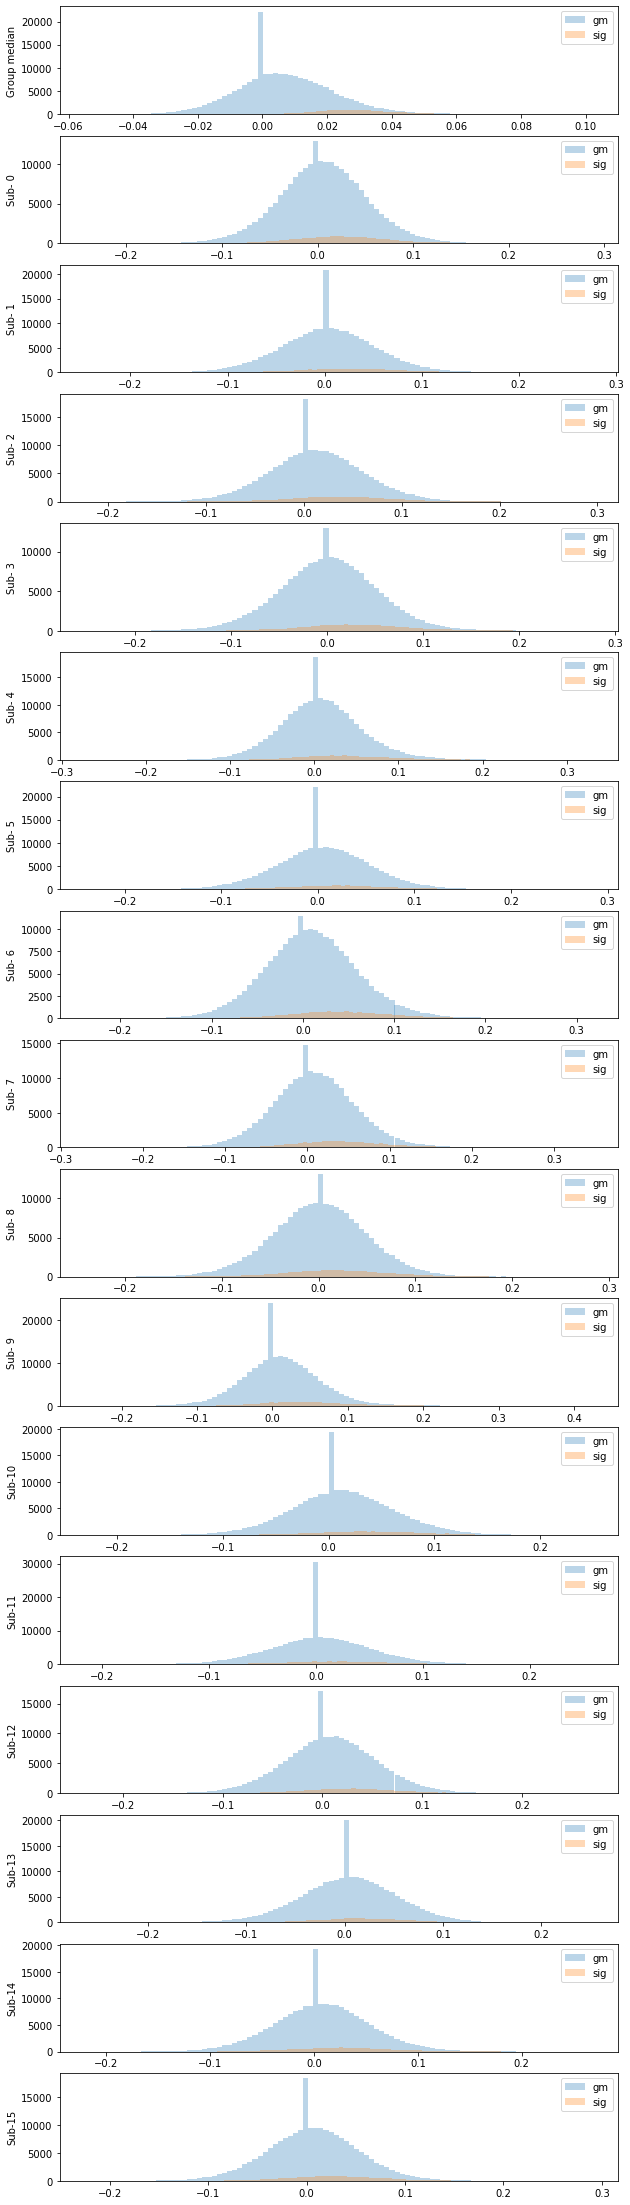

In [19]:
# visualize histograms per subject... how?
# load image
# load significance map
#load gray matter map
# for each subject, histogram of gray m atter with histogram of significance map
from nilearn.image import math_img
gm = pu.load_img(paths["root"], "derivatives", "standard", "masks", "grayMatter.nii.gz")
gm_bin = math_img('img > 0', img=gm)

sig = pu.load_img(paths["root"], "analysis", "group", "encoding", "n1000-ab_BARTpower_cv-relation_tfce_corrp_tstat1.nii.gz")
sig_bin = math_img('img > 0.95', img=sig)
result = pu.load_img(paths["root"], "analysis", "group", "encoding", "group-ab_BARTpower_cv-relation.nii.gz")

gm_result = pu.mask_img(result, mask=gm_bin)
sig_result = pu.mask_img(result, mask=sig_bin)

f, axarr = plt.subplots(17, figsize=(10, 40))

axarr[0].hist(np.median(gm_result, 0), alpha=0.3, label="gm", bins=100)
axarr[0].hist(np.median(sig_result, 0), alpha=0.3, label="sig", bins=100)
axarr[0].legend(loc="upper right")
axarr[0].set_ylabel("Group median")

for i in range(16):
    axarr[i+1].hist(gm_result[i], alpha=0.3, label="gm", bins=100)
    axarr[i+1].hist(sig_result[i], alpha=0.3, label="sig", bins=100)
    axarr[i+1].legend(loc="upper right")
    axarr[i+1].set_ylabel("Sub-{:2d}".format(i))
plt.show()

Reading file from: /u/project/monti/Analysis/Analogy/derivatives/standard/masks/grayMatter.nii.gz
Reading file from: /u/project/monti/Analysis/Analogy/analysis/group/encoding/n1000-ab_BARTnorm_cv-relation_tfce_corrp_tstat1.nii.gz
Reading file from: /u/project/monti/Analysis/Analogy/analysis/group/encoding/group-ab_BARTnorm_cv-relation.nii.gz
Applying mask
Applying mask


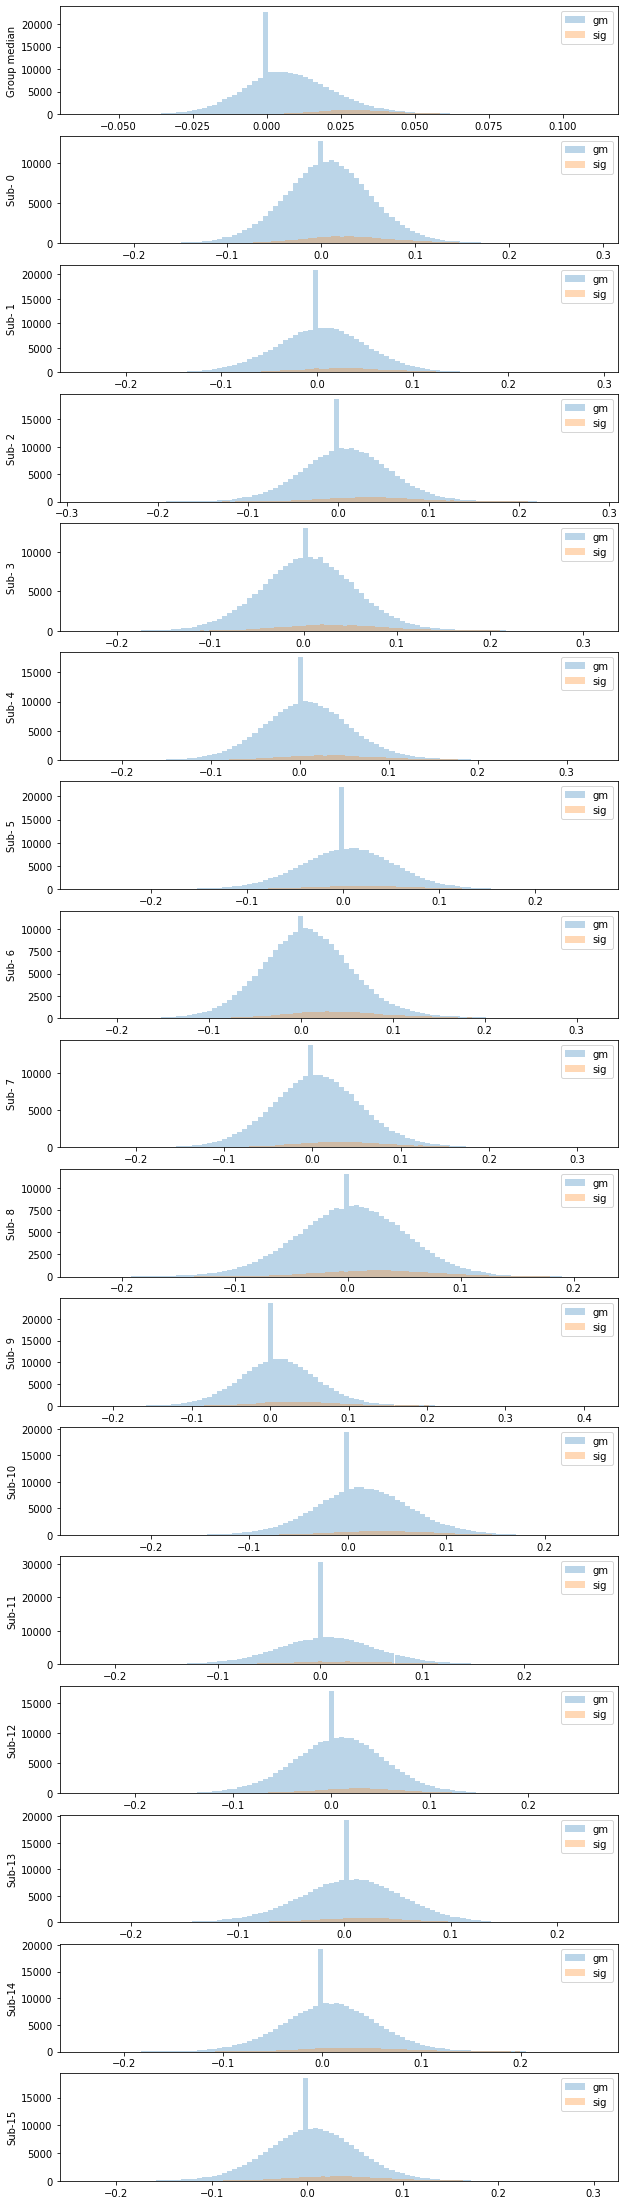

In [20]:
# visualize histograms per subject... how?
# load image
# load significance map
#load gray matter map
# for each subject, histogram of gray m atter with histogram of significance map
from nilearn.image import math_img
gm = pu.load_img(paths["root"], "derivatives", "standard", "masks", "grayMatter.nii.gz")
gm_bin = math_img('img > 0', img=gm)

sig = pu.load_img(paths["root"], "analysis", "group", "encoding", "n1000-ab_BARTnorm_cv-relation_tfce_corrp_tstat1.nii.gz")
sig_bin = math_img('img > 0.95', img=sig)
result = pu.load_img(paths["root"], "analysis", "group", "encoding", "group-ab_BARTnorm_cv-relation.nii.gz")

gm_result = pu.mask_img(result, mask=gm_bin)
sig_result = pu.mask_img(result, mask=sig_bin)

f, axarr = plt.subplots(17, figsize=(10, 40))

axarr[0].hist(np.median(gm_result, 0), alpha=0.3, label="gm", bins=100)
axarr[0].hist(np.median(sig_result, 0), alpha=0.3, label="sig", bins=100)
axarr[0].legend(loc="upper right")
axarr[0].set_ylabel("Group median")

for i in range(16):
    axarr[i+1].hist(gm_result[i], alpha=0.3, label="gm", bins=100)
    axarr[i+1].hist(sig_result[i], alpha=0.3, label="sig", bins=100)
    axarr[i+1].legend(loc="upper right")
    axarr[i+1].set_ylabel("Sub-{:2d}".format(i))
plt.show()

Reading file from: /u/project/monti/Analysis/Analogy/derivatives/standard/masks/grayMatter.nii.gz
Reading file from: /u/project/monti/Analysis/Analogy/analysis/group/encoding/n1000-ab_BART_cv-relation_tfce_corrp_tstat1.nii.gz
Reading file from: /u/project/monti/Analysis/Analogy/analysis/group/encoding/group-ab_BART_cv-relation.nii.gz
Applying mask
Applying mask


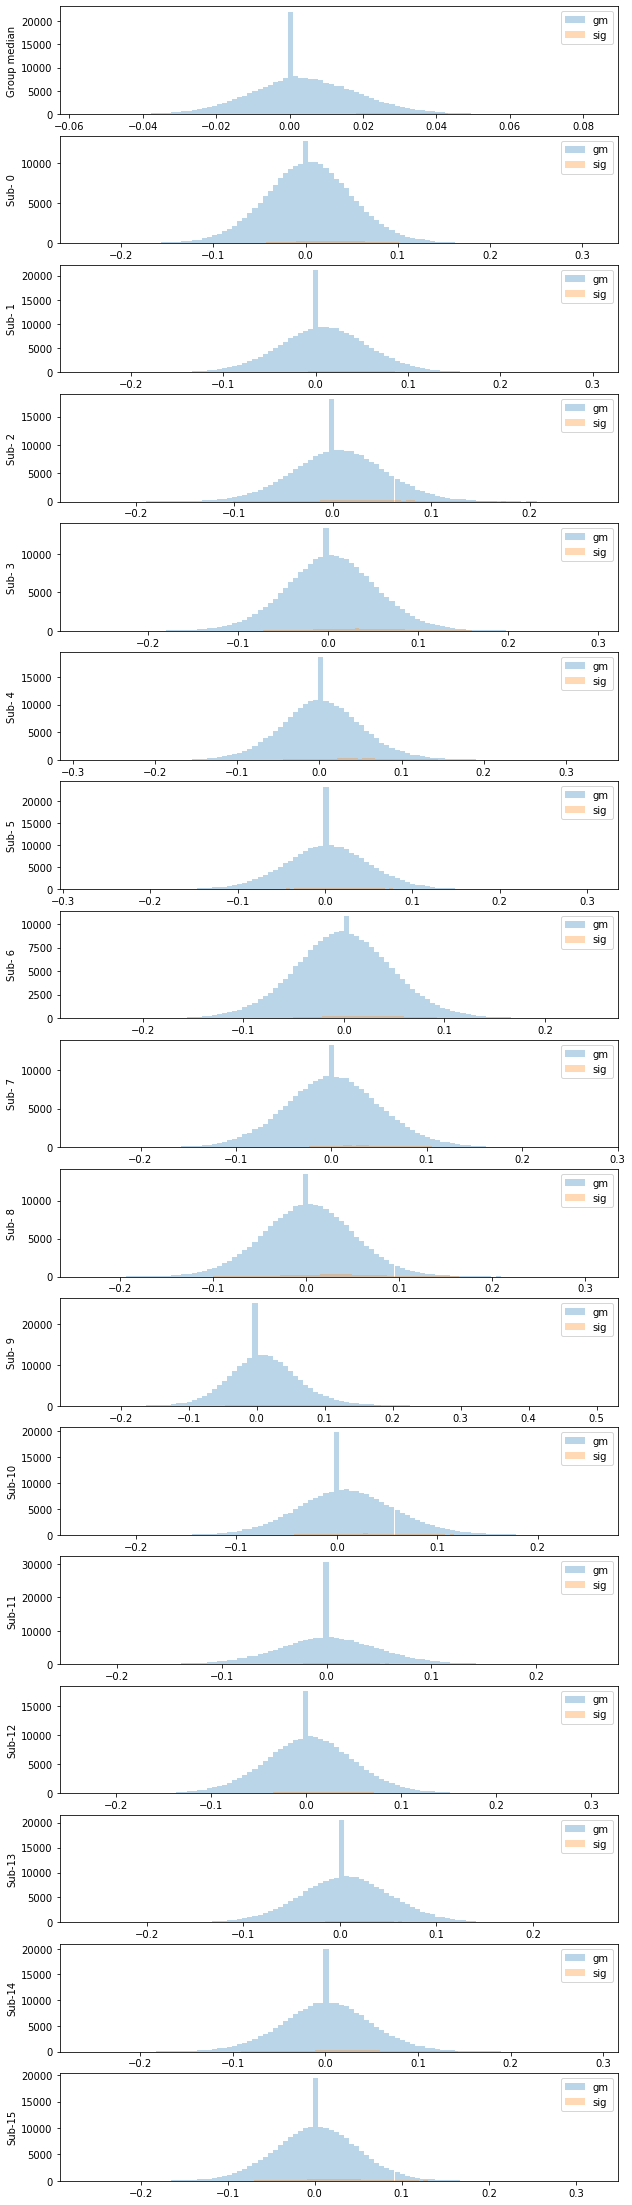

In [21]:
# visualize histograms per subject... how?
# load image
# load significance map
#load gray matter map
# for each subject, histogram of gray m atter with histogram of significance map
from nilearn.image import math_img
gm = pu.load_img(paths["root"], "derivatives", "standard", "masks", "grayMatter.nii.gz")
gm_bin = math_img('img > 0', img=gm)

sig = pu.load_img(paths["root"], "analysis", "group", "encoding", "n1000-ab_BART_cv-relation_tfce_corrp_tstat1.nii.gz")
sig_bin = math_img('img > 0.95', img=sig)
result = pu.load_img(paths["root"], "analysis", "group", "encoding", "group-ab_BART_cv-relation.nii.gz")

gm_result = pu.mask_img(result, mask=gm_bin)
sig_result = pu.mask_img(result, mask=sig_bin)

f, axarr = plt.subplots(17, figsize=(10, 40))

axarr[0].hist(np.median(gm_result, 0), alpha=0.3, label="gm", bins=100)
axarr[0].hist(np.median(sig_result, 0), alpha=0.3, label="sig", bins=100)
axarr[0].legend(loc="upper right")
axarr[0].set_ylabel("Group median")

for i in range(16):
    axarr[i+1].hist(gm_result[i], alpha=0.3, label="gm", bins=100)
    axarr[i+1].hist(sig_result[i], alpha=0.3, label="sig", bins=100)
    axarr[i+1].legend(loc="upper right")
    axarr[i+1].set_ylabel("Sub-{:2d}".format(i))
plt.show()

In [14]:
# visualize betas (take mean of each sub relation, normalize to 0 1 and concatenate)